# 10-5 VGG for cifar10

## original code is =>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

''

## define loss tracker

In [3]:
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=loss_value,
             win = loss_plot,
             update='append'
             )

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


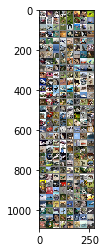

truck   dog horse truck


In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
vis.images(images/2 + 0.5)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## make VGG16 using vgg.py

In [7]:
import vgg

In [8]:
cfg = [32,32,64,64,'M',128,128,128,'M',256,256,256,'M',512,512,512]

In [9]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [10]:
vgg16= VGG(vgg.make_layers(cfg),10,True).to(device)

In [11]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)
   

In [12]:
a=torch.Tensor(1,3,32,32).to(device)
out = vgg16(a)
print(out)

tensor([[-0.0004, -0.0005, -0.0020, -0.0014, -0.0014,  0.0003,  0.0014,  0.0005,
          0.0017,  0.0019]], device='cuda:0', grad_fn=<AddmmBackward>)


In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(vgg16.parameters(), lr = 0.001, momentum = 0.9)

## make plot

In [ ]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

## training

In [ ]:
print(len(trainloader))
epochs = 30

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 2000 mini-batches
            loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
        

print('Finished Training')

196
[1,    30] loss: 2.302
[1,    60] loss: 2.302
[1,    90] loss: 2.302
[1,   120] loss: 2.301
[1,   150] loss: 2.301
[1,   180] loss: 2.300
[2,    30] loss: 2.299
[2,    60] loss: 2.298
[2,    90] loss: 2.296
[2,   120] loss: 2.293
[2,   150] loss: 2.286
[2,   180] loss: 2.272
[3,    30] loss: 2.255
[3,    60] loss: 2.233
[3,    90] loss: 2.218
[3,   120] loss: 2.198
[3,   150] loss: 2.180
[3,   180] loss: 2.151
[4,    30] loss: 2.132
[4,    60] loss: 2.128
[4,    90] loss: 2.089
[4,   120] loss: 2.088
[4,   150] loss: 2.061
[4,   180] loss: 2.038
[5,    30] loss: 2.008
[5,    60] loss: 1.969


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = vgg16(images.to(device))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))